<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. .

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Цель проекта

Цель проекта состоит в построении модели, предсказывающая температуру сплава

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Описание технологического процесса
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. 
1. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
2. Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы.Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом.
3. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
4. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">


## Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).
 
1. data_arc_new.csv
   - key — номер партии;
   - Начало нагрева дугой — время начала нагрева;
   - Конец нагрева дугой — время окончания нагрева;
   - Активная мощность — значение активной мощности;
   - Реактивная мощность — значение реактивной мощности.
2. data_bulk_new.csv
   - key — номер партии;
   - Bulk 1 … Bulk 15 — объём подаваемого материала.
3. data_bulk_time_new.csv
   - key — номер партии;
   - Bulk 1 … Bulk 15 — время подачи материала.
4. Файл data_gas_new.csv
    - key — номер партии;
    - Газ 1 — объём подаваемого газа.
5. Файл data_temp_new.csv
    - key — номер партии;
    - Время замера — время замера;
    - Температура — значение температуры.
6. Файл data_wire_new.csv
    - key — номер партии;
    - Wire 1 … Wire 15 — объём подаваемых проволочных материалов.
7. Файл data_wire_time_new.csv
    - key — номер партии;
    - Wire 1 … Wire 15 — время подачи проволочных материалов.

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">


## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import phik
import shap

warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

plt.rcParams['figure.figsize'] = [16,16]
from time import time

C:\Users\Alexander\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
try:
    data_arc_new = pd.read_csv('data_arc_new.csv')
    data_bulk_new = pd.read_csv('data_bulk_new.csv')
    data_wire_new = pd.read_csv('data_wire_new.csv')
    data_bulk_time_new = pd.read_csv('data_bulk_time_new.csv')
    data_wire_time_new = pd.read_csv('data_wire_time_new.csv')
    data_gas_new = pd.read_csv('data_gas_new.csv')
    data_temp_new = pd.read_csv('data_temp_new.csv')

except:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')

In [3]:
pd.set_option('display.max_columns', None)

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

### Предобработка и исследовательский анализ данных

In [4]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [5]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [6]:
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


В данном датафрейме отсутсвуют пропуски, столбцы со временем имеют неправильный тип данных. По описанию данных можно заметить отрицательные значения от которых нужно будет избавиться.

In [7]:
data_arc_new = data_arc_new.rename(columns={
    'Начало нагрева дугой': 'begin_arc_heat',
    'Конец нагрева дугой' : 'end_arc_heat',
    'Активная мощность' : 'active_power',
    'Реактивная мощность' : 'reactive_power'
})

In [8]:
data_arc_new.head()

,key,begin_arc_heat,end_arc_heat,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


In [9]:
# Заведем список ключей, которые удалим
index = []
index.extend(data_arc_new.query('(active_power < 0) | (reactive_power < 0 )')['key'].to_list())

Добавим новый столбец: полную мощность, изменим тип данных для столбцов со временем и добавим новый столбец - длительность нагрева электродов

In [10]:
data_arc_new['total_power'] = np.sqrt(data_arc_new['active_power'] ** 2 + data_arc_new['reactive_power'] ** 2)

In [11]:
data_arc_new[['begin_arc_heat','end_arc_heat']] = data_arc_new[['begin_arc_heat','end_arc_heat']].astype('datetime64[ns]')

In [12]:
data_arc_new['delta_arc_heat'] = (data_arc_new['end_arc_heat'] - data_arc_new['begin_arc_heat']).dt.total_seconds()

In [13]:
data_arc_new.head()

,key,begin_arc_heat,end_arc_heat,active_power,reactive_power,total_power,delta_arc_heat
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148.0


In [14]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [15]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [16]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


В данных о подаче сыпучих материалов видно большое количество пропусков, так для **Bulk 8** используется одно значение. Также необходимо будет отредактировать название столбцов и заменить пропуски нулями. 

In [17]:
data_bulk_new = data_bulk_new.fillna(0)

In [18]:
for i in range(1, data_bulk_new.shape[1]):
    data_bulk_new = data_bulk_new.rename(columns={data_bulk_new.columns[i] : '_'.join(data_bulk_new.columns[i].split()) })

In [19]:
data_bulk_new.head()

,key,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [20]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [21]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Как и для предыдущего датафрейма изменим названия столбцов и заменим пропущенные данные нулями

In [23]:
data_wire_new = data_wire_new.fillna(0)

In [24]:
for i in range(1, data_wire_new.shape[1]):
    data_wire_new = data_wire_new.rename(columns={data_wire_new.columns[i] : '_'.join(data_wire_new.columns[i].split()) })

In [25]:
data_wire_new.head()

,key,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [27]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [28]:
data_temp_new.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


В таблице присутствуют пропуски температур и значения меньше 1500 градусов. Такие данные мы удалим.

In [29]:
data_temp_new = data_temp_new.rename(columns={'Время замера': 'time_zamer',
                                              'Температура': 'temperature'})

In [30]:
data_temp_new.head()

,key,time_zamer,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [31]:
index.extend(data_temp_new.query('temperature < 1500')['key'].to_list())

In [32]:
d = data_temp_new.groupby('key')['temperature'].count()

In [33]:
index.extend(d[d < 2].index.to_list())

In [34]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [35]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [36]:
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Также заменим названия столбцов. Пропуски отсутсвуют.

In [37]:
data_gas_new = data_gas_new.rename(columns={'Газ 1': 'gas'})

In [38]:
data_gas_new.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

### Вывод по предобработке данных  

1. В данных об электродах отсутсвуют пропуски, столбцы со временем имеют неправильный тип данных. По описанию данных можно заметить отрицательные значения реактивной мощности от которых нужно будет избавиться. Были добавлены новые столбцы: полная мощность, длительность нагрева электродов.
2. В данных о подаче сыпучих материалов видно большое количество пропусков, так для **Bulk_8** используется одно значение. Пропуски были заменены нулями.
3. В данных о подаче проволочек заменили пропущенные данные нулями
4. В таблице присутствуют пропуски температур и значения меньше 1500 градусов. Такие данные необходимо удалить.

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Объединение данных

Выделим температуры которые соответсвует первой и последней итерации. Наша задача состоит определить конечную температуру сплава

In [39]:
temp = data_temp_new.groupby('key')['temperature'].agg(['first', 'last'])

Сгруппируем данные по ключу и определим суммарную мощность электродов и ивремя нагрева сплава

In [40]:
data = data_arc_new.groupby('key')[['active_power', 'reactive_power', 'total_power', 'delta_arc_heat']].sum()

In [41]:
data = data.merge(data_bulk_new, on='key', how='inner')
data = data.merge(data_wire_new, on='key', how='inner')
data = data.merge(temp, on='key', how='inner')
data = data.merge(data_gas_new, on='key', how='inner')

In [42]:
data.shape

(3022, 32)

Удалим из объединненого датафрейма ключи которые не соответсвуют требованиям:

- Температура сплава меньше 1500 градусов
- Один замер температуры
- Реактивная мощность имеет отрицательное значение 

In [43]:
data = data[~ data['key'].isin(index)]

In [44]:
data.shape

(2324, 32)

In [45]:
data.head()

,key,active_power,reactive_power,total_power,delta_arc_heat,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9,first,last,gas
0,1,3.036730,2.142821,3.718736,1098.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1613.0,29.749986
1,2,2.139408,1.453357,2.588349,811.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1581.0,1602.0,12.555561
2,3,4.063641,2.937457,5.019223,655.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1596.0,1599.0,28.554793
3,4,2.706489,2.056992,3.400038,741.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1601.0,1625.0,18.841219
4,5,2.252950,1.687991,2.816980,869.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1576.0,1602.0,5.413692


In [46]:
data.tail()

,key,active_power,reactive_power,total_power,delta_arc_heat,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9,first,last,gas
2324,2495,3.168133,2.210936,3.868721,723.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1570.0,1591.0,7.125735
2325,2496,4.174918,2.872031,5.070316,940.0,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1554.0,1591.0,9.412616
2326,2497,3.605239,2.452092,4.360918,569.0,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1571.0,1589.0,6.271699
2327,2498,3.202310,2.239820,3.909917,750.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1591.0,1594.0,14.953657
2328,2499,1.737084,1.296836,2.169252,883.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0,0.0,126.0,227.0,110.160958,50.00528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1569.0,1603.0,11.336151


В окончательном варианте осталось 2329 строчек и 2499 ключей

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Вывод по объединению данных

Для объеденения данных были удалены ключи по следущим требованиям: 
- Температура сплава меньше 1500 градусов
- Один замер температуры
- Реактивная мощность имеет отрицательное значение

В объедененный датафрейм вошли температуры, соответствующие первой и последней итерации. Нашей задачей является предсказание конечную температуру.
В окончательном варианте осталось 2329 строчек и 2499 ключей

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Исследовательский анализ данных

Напишем функции для построения гистограм и боксплотов

In [47]:
def num_plot(data, lst=[], row=2):
    num_col = data.select_dtypes(include='number').columns.to_list()
    a = row 
    b = len(num_col) // a + 1
    c = 1
    for cl,label in zip(num_col, lst):
        plt.subplot(a,b,c)
        sns.histplot(data[cl], kde=True)
        plt.xlabel(label)
        plt.ylabel('Количество')
        plt.axvline(data[cl].median(), color='r', ymin=0, ymax= 0.95, ls='--')
        c += 1
        
    plt.tight_layout()    
    plt.show()

In [48]:
def box_plot(data,lst, row=2):
    num_col = data.select_dtypes(include='number').columns.to_list()
    a = row
    b = len(num_col) // a + 1
    c = 1
    for cl,label in zip(num_col, lst):
        plt.subplot(a,b,c)
        sns.boxplot(data[cl])
        plt.xlabel(label)
        c += 1
    plt.tight_layout()
    plt.show()

In [49]:
data.describe()

,key,active_power,reactive_power,total_power,delta_arc_heat,Bulk_1,Bulk_2,Bulk_3,Bulk_4,Bulk_5,Bulk_6,Bulk_7,Bulk_8,Bulk_9,Bulk_10,Bulk_11,Bulk_12,Bulk_13,Bulk_14,Bulk_15,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9,first,last,gas
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.0,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,1251.140275,3.126327,2.301280,3.886143,808.196644,3.435026,1.425559,47.317126,37.347676,2.645869,22.419535,2.009036,0.021084,0.445783,5.063683,4.254303,208.597676,1.069707,153.952668,120.078313,102.423900,17.613213,3.241876,0.307209,0.0,0.980926,0.006374,0.311981,0.317795,1587.368761,1593.372633,11.378854
std,715.027927,1.220484,0.903711,1.517584,340.813828,12.424463,19.102530,75.238050,58.677890,22.426054,55.792509,30.709089,1.016431,6.227298,20.938984,22.538843,157.112117,14.250280,81.410544,84.655967,43.540975,33.648176,27.972523,4.762842,0.0,8.702531,0.205926,4.407419,3.460248,23.627590,11.207457,6.397008
min,1.000000,0.267676,0.196228,0.331897,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1519.000000,1541.000000,0.008399
25%,628.750000,2.295960,1.671099,2.846893,581.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,73.204559,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1571.000000,1587.000000,7.282534
50%,1254.500000,3.036517,2.225900,3.770584,778.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,101.103600,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1587.000000,1593.000000,10.100687
75%,1867.250000,3.834302,2.829179,4.769753,993.000000,0.000000,0.000000,80.000000,77.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,283.000000,0.000000,204.000000,204.000000,128.075222,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1603.000000,1598.000000,14.218487
max,2499.000000,12.375636,8.949049,15.288271,4189.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600,1660.000000,1653.000000,77.995040


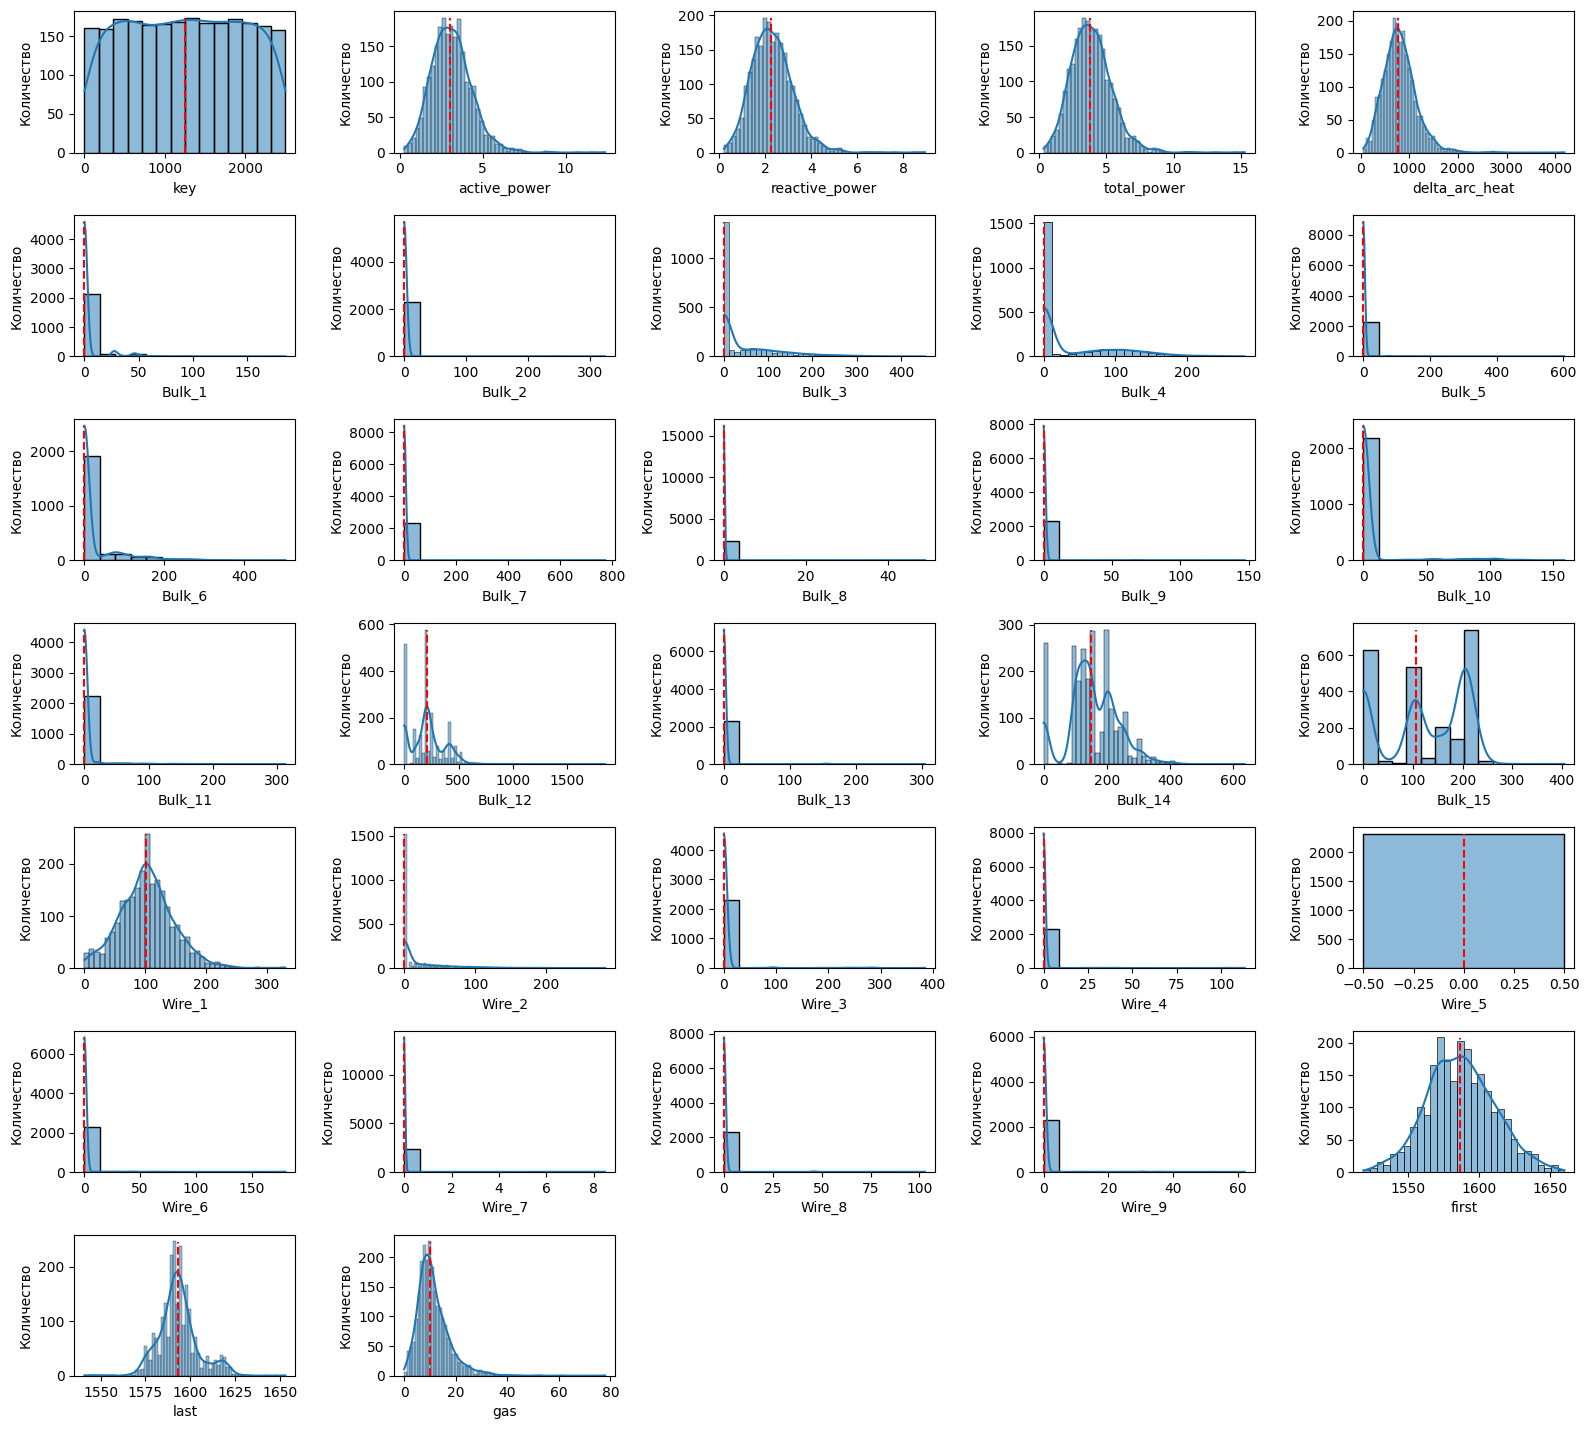

In [50]:
num_plot(data, data.columns,8)

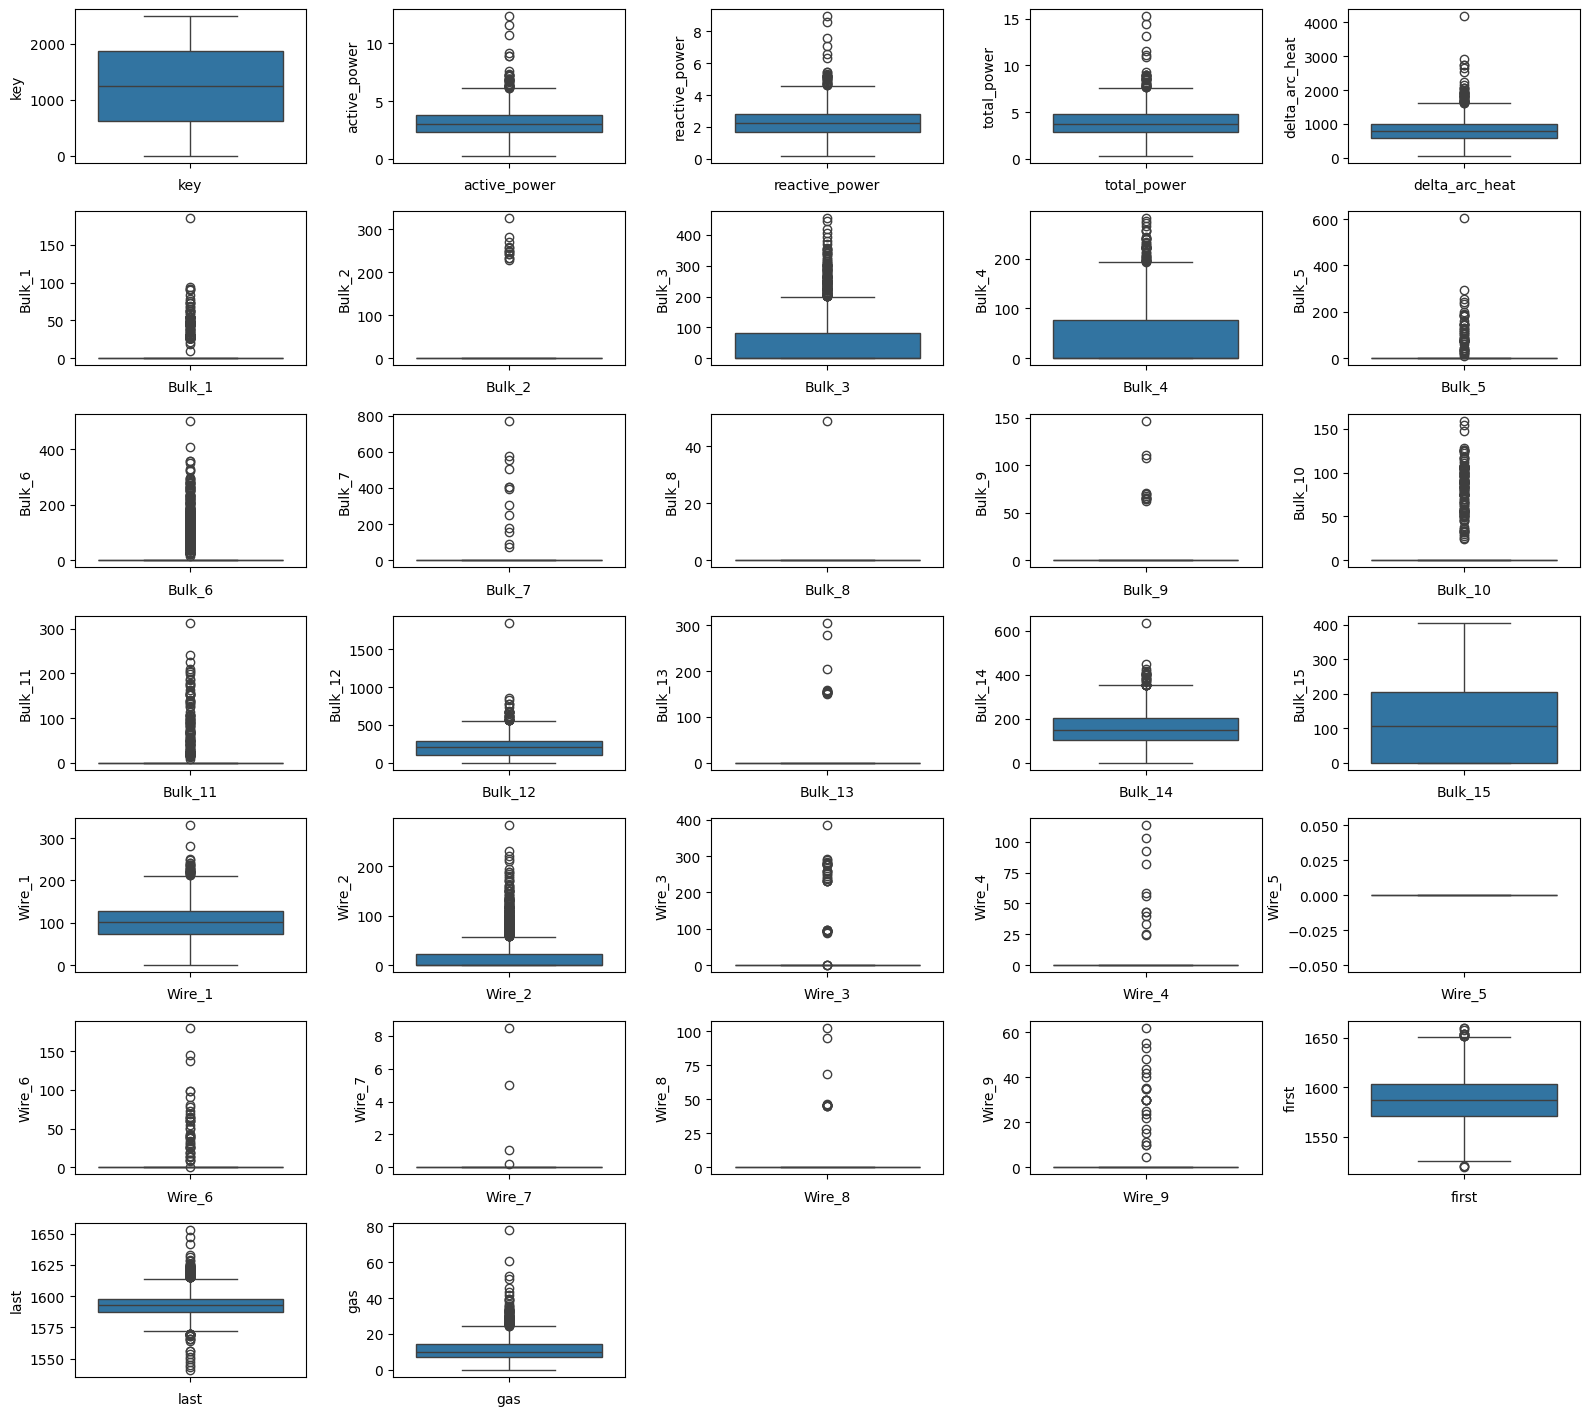

In [51]:
box_plot(data, data.columns, 8)

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Вывод по исследовательскому анализу данных

Построив графики, можно заметить, что данные мощности, начальной температуры, объема газа, суммарного нагрева электродами имеет распределение близкое к нормальному с длинным правым хвостом. Конечная температура имеет вид близкий к нормальному распределению с длинными хвостами. Данные о сыпучих материалах и проволочках присутствует много не информативных признаков, имеющие большое количество пропусков, которые ранее были заменены на нулевое значение. 

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Корреляционный анализ

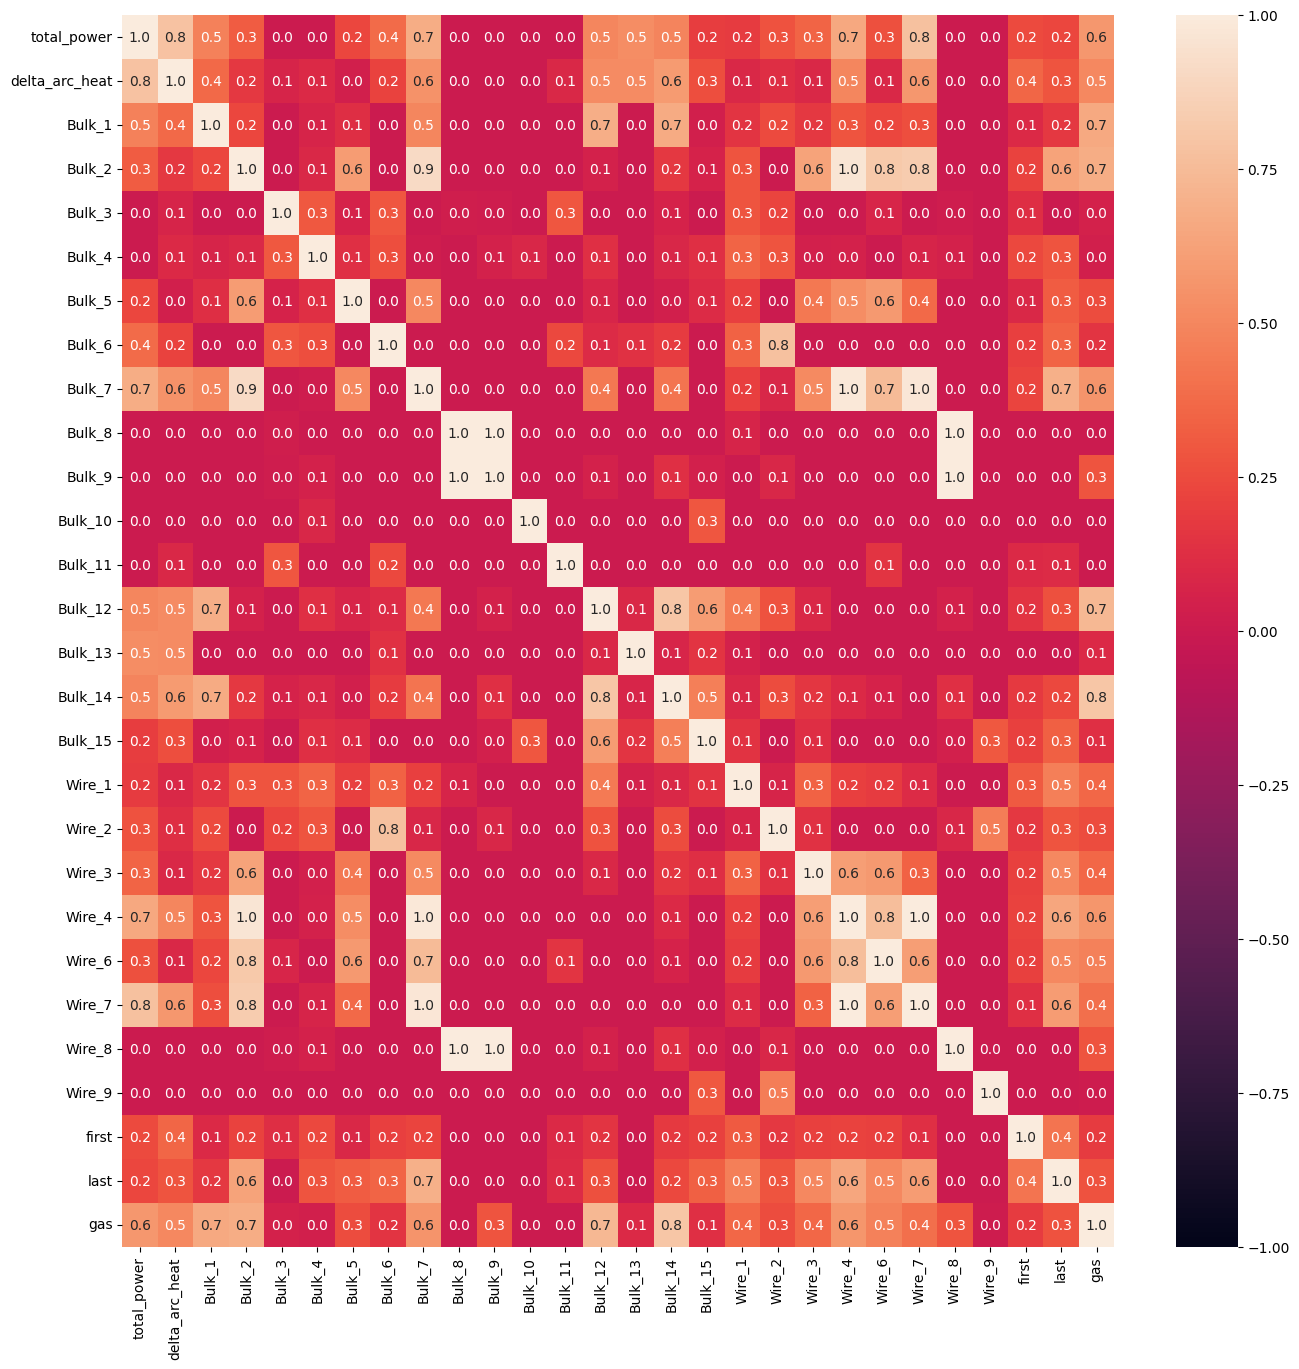

In [52]:
sns.heatmap(phik.phik_matrix(data.drop(['key','active_power', 'reactive_power'], axis=1), interval_cols=data.select_dtypes(include='number').columns), annot=True, fmt='.1f', vmax=1, vmin=-1)
plt.show()

Уберем признаки с высоким коэффициентом корреляции

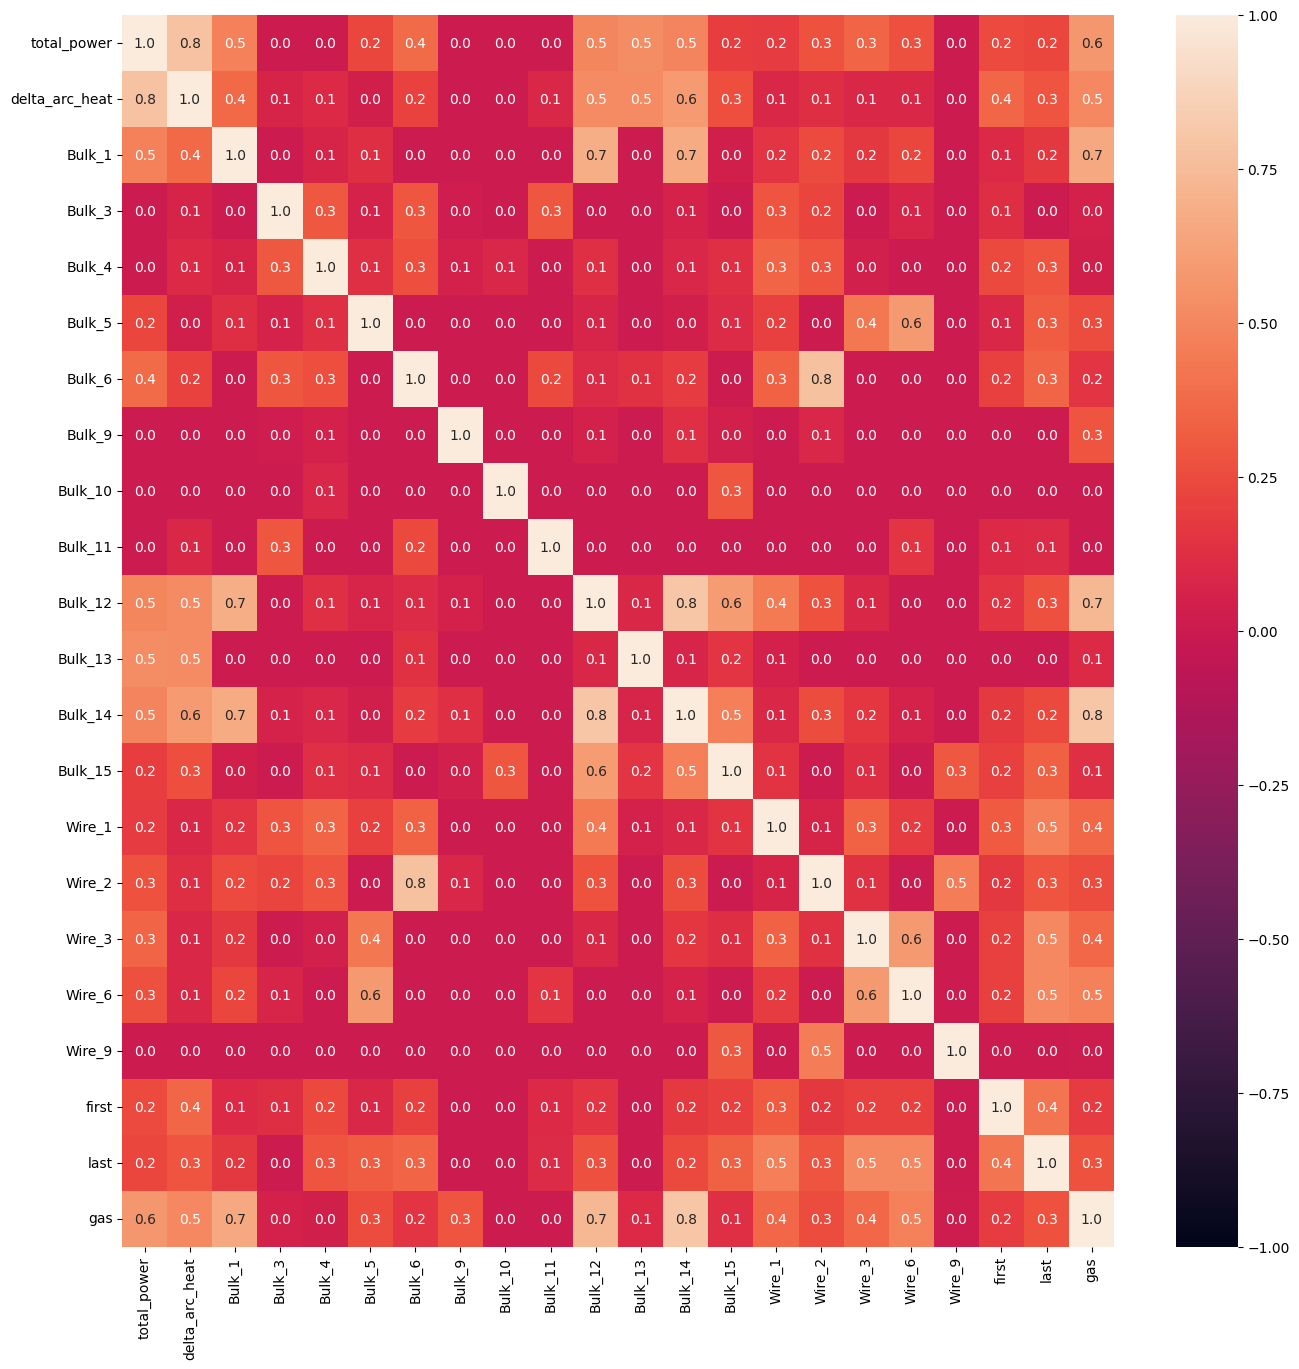

In [53]:
sns.heatmap(phik.phik_matrix(data.drop(['key','active_power', 'reactive_power','Bulk_2', 'Bulk_7', 'Bulk_8', 'Wire_4', 'Wire_7', 'Wire_8', 'Wire_5'], axis=1), interval_cols=data.select_dtypes(include='number').columns), annot=True, fmt='.1f', vmax=1, vmin=-1)
plt.show()

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Вывод по корреляционному анализу

Была построена тепловая карта корреляционной матрицы признаков. В ходе анализа были удалены сильно коррелированные признаки. Конечная температура с признаками в основном слабо или умеренно коррелирует.

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Обучение моделей

In [54]:
RANDOM_STATE = 220424

Удалим ненужные признаки

In [55]:
X = data.drop(['key','active_power', 'reactive_power','Bulk_2', 'Bulk_7', 'Bulk_8', 'Wire_4', 'Wire_7', 'Wire_8', 'Wire_5', 'last'], axis=1)
y = data['last']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=RANDOM_STATE, test_size=0.25)

In [57]:
X_train.shape

(1743, 21)

In [58]:
dummy = DummyRegressor()

In [59]:
dummy.fit(X_train,y_train)
y_pred = dummy.predict(X_test)
print(f'MAE dummy regression = {round(mean_absolute_error(y_test,y_pred),2)}')

MAE dummy regression = 7.78


In [60]:
num_col = X.select_dtypes(include='number').columns.to_list()

In [61]:
preprocessing = ColumnTransformer([('num', StandardScaler(), num_col)], remainder='passthrough')

In [62]:
final_p = Pipeline([
    ('preprocessor', preprocessing),
    ('models', LinearRegression())
])

In [63]:
param_grid = [
    {
        'models': [LinearRegression()],
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, metric='mae',learning_rate=0.05)],
        'models__max_depth': [i for i in range(7,10)],
        'models__num_leaves': [i for i in range(20,30)],
        'models__min_child_samples' : [i for i in range(7, 10)],
        'preprocessor__num':[StandardScaler()] #, MinMaxScaler(), RobustScaler()]
    }
]

In [64]:
randomized = RandomizedSearchCV(final_p, param_grid,cv=4,random_state=RANDOM_STATE,n_iter=20, scoring='neg_mean_absolute_error')

In [65]:
start = time()
randomized.fit(X_train,y_train)
end = time()
print(f'Время работы {(end - start) / 60} минут')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2056
[LightGBM] [Info] Number of data points in the train set: 1307, number of used features: 19
[LightGBM] [Info] Start training from score 1593.374139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [66]:
randomized.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['total_power',
                                                   'delta_arc_heat', 'Bulk_1',
                                                   'Bulk_3', 'Bulk_4', 'Bulk_5',
                                                   'Bulk_6', 'Bulk_9',
                                                   'Bulk_10', 'Bulk_11',
                                                   'Bulk_12', 'Bulk_13',
                                                   'Bulk_14', 'Bulk_15',
                                                   'Wire_1', 'Wire_2', 'Wire_3',
                                                   'Wire_6', 'Wire_9', 'first',
                                                   'gas'])])),
                ('models',
                 LGBMRegressor(learning_rate=0.05, max_depth=9, metric='mae',
                               min_child_samples=8, num_leaves=22,
                               random_state=220424))])

In [67]:
print(f'MAE best model: {round((-1) * randomized.best_score_,2)}')

MAE best model: 6.21


In [68]:
result = pd.DataFrame(randomized.cv_results_)
result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head(5)

,rank_test_score,param_models,mean_test_score,params
15,1,"LGBMRegressor(learning_rate=0.05, metric='mae'...",-6.214057,"{'preprocessor__num': StandardScaler(), 'model..."
14,2,"LGBMRegressor(learning_rate=0.05, metric='mae'...",-6.218880,"{'preprocessor__num': StandardScaler(), 'model..."
13,3,"LGBMRegressor(learning_rate=0.05, metric='mae'...",-6.219189,"{'preprocessor__num': StandardScaler(), 'model..."
6,4,"LGBMRegressor(learning_rate=0.05, metric='mae'...",-6.222764,"{'preprocessor__num': StandardScaler(), 'model..."
10,5,"LGBMRegressor(learning_rate=0.05, metric='mae'...",-6.223120,"{'preprocessor__num': StandardScaler(), 'model..."


Лучшей модель стала LGBMRegressor с параметрами learning_rate=0.05, max_depth=9, min_child_samples=9, num_leaves=21 с метрикой MAE = 6.13 с маштабированием данных с помощью StandardScaler

Оценим важность признаков с помощью библиотеки shap

In [69]:
best_model = randomized.best_estimator_

In [70]:
sc = randomized.best_estimator_['preprocessor'].transformers[0][1]
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
best_model_shap = randomized.best_estimator_['models'].fit(X_train_sc,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2231
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 21
[LightGBM] [Info] Start training from score 1593.492828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [71]:
explainer = shap.TreeExplainer(best_model_shap, X_train_sc)
shap_values = explainer(X_train_sc)

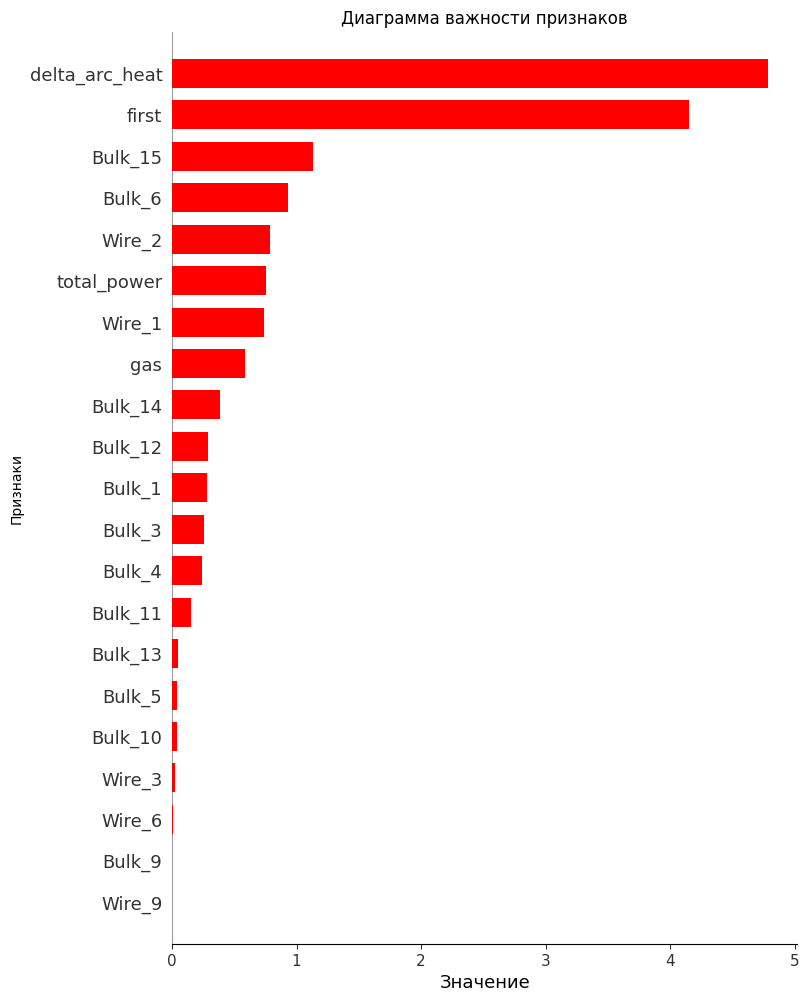

In [72]:
shap.summary_plot(shap_values, X_train_sc, plot_type="bar", show=False, color='red', max_display = 30)
plt.ylabel('Признаки')
plt.xlabel('Значение')
plt.title('Диаграмма важности признаков')
plt.show()

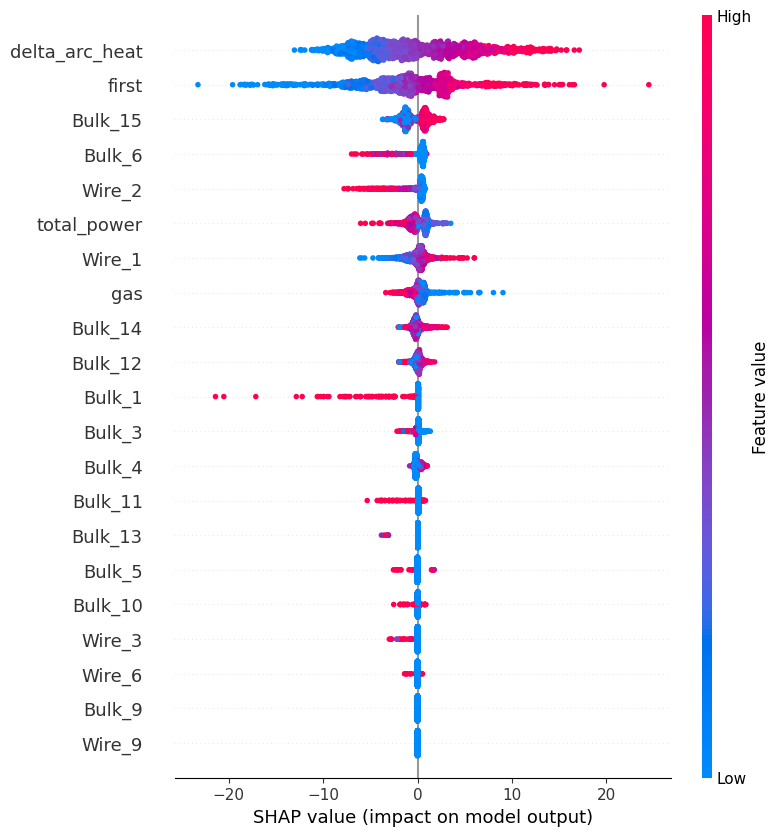

In [73]:
shap.plots.beeswarm(shap_values, max_display=31)

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

## Вывод по анализу важности признаков

- Признаки Bulk_9, Wire_9 для нашей модели не информативны и поэтому удалим эти признаки. Из всех признаков выделяются два важных признака: Начальная температура и суммарное время нагрева электродами.
- Так мы можем увидеть, что при увеличении начальной температуры и времени нагрева электродами растет конечная температура. Такой же характер и у Bulk_15. А вот Bulk_6, Wire_2, объем газа и полной мощности при увеличении ведет к снижению температуры.

In [74]:
X = X.drop(['Bulk_9', 'Wire_9'], axis=1)

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=RANDOM_STATE, test_size=0.25)

In [76]:
num_col_new = X.select_dtypes(include='number').columns.to_list()

In [77]:
preprocessing_new = ColumnTransformer([('num', StandardScaler(), num_col_new)], remainder='passthrough')

In [78]:
final_p_new = Pipeline([
    ('preprocessor', preprocessing_new),
    ('models', LinearRegression())
])

In [79]:
param_grid_new =  [
    {
        'models': [LinearRegression()],
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, metric='mae',learning_rate=0.05)],
        'models__max_depth': [i for i in range(7,10)],
        'models__num_leaves': [i for i in range(20,30)],
        'models__min_child_samples' : [i for i in range(7, 10)],
        'preprocessor__num':[StandardScaler()] #, MinMaxScaler(), RobustScaler()]
    }
]

In [80]:
randomized_1 = RandomizedSearchCV(final_p_new, param_grid_new,cv=5,random_state=RANDOM_STATE,n_iter=20,n_jobs=-1, scoring='neg_mean_absolute_error')

In [81]:
%%time
randomized_1.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2218
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 19
[LightGBM] [Info] Start training from score 1593.492828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: total: 734 ms
Wall time: 7.17 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['total_power',
                                                                                'delta_arc_heat',
                                                                                'Bulk_1',
                                                                                'Bulk_3',
                                                                                'Bulk_4',
                                                                                'Bulk_5',
                                                                                'Bulk_6',
                                                                                'Bulk_10',
                                                                                'Bulk_11',
                                                                                'Bulk_12',
                                                                                'Bulk_13',
                                                                                'Bulk_14',
                                                                                'Bulk_15',
                                                                                'Wire_1',
                                                                                'Wire_2',
                                                                                'Wire_3',
                                                                                'Wire_6',
                                                                                'first',
                                                                                'gas'])])),
                                             ('models', Li...
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()]},
                                        {'models': [LGBMRegressor(learning_rate=0.05,
                                                                  metric='mae',
                                                                  random_state=220424)],
                                         'models__max_depth': [7, 8, 9],
                                         'models__min_child_samples': [7, 8, 9],
                                         'models__num_leaves': [20, 21, 22, 23,
                                                                24, 25, 26, 27,
                                                                28, 29],
                                         'preprocessor__num': [StandardScaler()]}],
                   random_state=220424, scoring='neg_mean_absolute_error')

In [82]:
randomized_1.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['total_power',
                                                   'delta_arc_heat', 'Bulk_1',
                                                   'Bulk_3', 'Bulk_4', 'Bulk_5',
                                                   'Bulk_6', 'Bulk_10',
                                                   'Bulk_11', 'Bulk_12',
                                                   'Bulk_13', 'Bulk_14',
                                                   'Bulk_15', 'Wire_1',
                                                   'Wire_2', 'Wire_3', 'Wire_6',
                                                   'first', 'gas'])])),
                ('models',
                 LGBMRegressor(learning_rate=0.05, max_depth=9, metric='mae',
                               min_child_samples=7, num_leaves=22,
                               random_state=220424))])

In [83]:
print(f'MAE best model: {(-1) * round(randomized_1.best_score_,2)}')

MAE best model: 6.1


In [84]:
y_pred = randomized_1.best_estimator_.predict(X_test)

In [85]:
print(f'MAE test: {round(mean_absolute_error(y_test, y_pred),2)}')

MAE test: 6.36


In [86]:
print(f'R2 test: {round(r2_score(y_test, y_pred),2)}')

R2 test: 0.3


Коэффициент детерминации R2 = 0.3. Низкое значение можно объяснить небольшой дисперсией конечной температуры

<div style="border-radius: 15px; box-shadow: 2px 2px 4px; border: 1px solid; background:OldLace; padding: 20px">

# Вывод

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. 

В ходе работы были выполнены следующие этапы:
1. Предобработка данных
2. Объединение данных
3. Исследовательский анализ данных
4. Корреляционный анализ
5. Обучение модели
6. Анализ важности признаков

- В данных об электродах отсутсвуют пропуски, столбцы со временем имеют неправильный тип данных. По описанию данных можно заметить отрицательные значения реактивной мощности от которых нужно будет избавиться. Были добавлены новые столбцы: полная мощность, длительность нагрева электродов.
- В данных о подаче сыпучих материалов видно большое количество пропусков, так для **Bulk_8** используется одно значение. Пропуски были заменены нулями.
- В данных о подаче проволочек заменили пропущенные данные нулями
- В таблице присутствуют пропуски температур и значения меньше 1500 градусов. Такие данные необходимо удалить
- Построив графики, можно заметить, что данные мощности, начальной температуры, объема газа, суммарного нагрева электродами имеет распределение близкое к нормальному с длинным правым хвостом. Конечная температура имеет вид близкий к нормальному распределению с длинными хвостами. Данные о сыпучих материалах и проволочках присутствует много не информативных признаков, имеющие большое количество пропусков, которые ранее были заменены на нулевое значение.
- Была построена тепловая карта корреляционной матрицы признаков. В ходе анализа были удалены сильно коррелированные признаки. Конечная температура с признаками в основном слабо или умеренно коррелирует.
- Признаки Bulk_9, Wire_9 для нашей модели не информативны и поэтому были удалены. Из всех признаков выделяются два важных признака: Начальная температура и суммарное время нагрева электродами.
- Так мы можем увидеть, что при увеличении начальной температуры и времени нагрева электродами растет конечная температура. Такой же характер и у Bulk_15. А вот Bulk_6, Wire_2, объем газа и полной мощности при увеличении ведет к снижению температуры.
- В конечном результате лучшей моделью стала LGBMRegressor(learning_rate=0.05, max_depth=9,  min_child_samples=7, num_leaves=23, random_state=220424
со значением на тренировочных данных $MAE = 6.08$ и на тесте $MAE = 6.32$
- Коэффициент детерминации $R2 = 0.3$. Низкое значение можно объяснить небольшой дисперсией конечной температуры.)